## Womanium Quantum Classiq Assignment 6.12:

We intend to apply the Discrete Quantum Walk algorithm to a particular instance of graph connectivity for any desired (originally 16) nodes, mutually connected by edges in the following manner: 

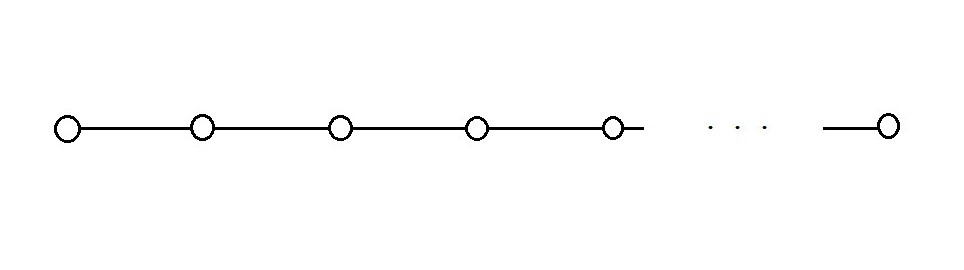

## A general high-level view of all the contributing parts of this algorithm:

This is the quantum analog of the imlementation of clasical random walk wherein for determining the next step, all paths are equally probable and this choice should be randomly adopted! Ultimately there should be a unitary operation (QM) that brings the vertex i to the superposition of its adjacent vertices. Now there are two essential prereuisites to the quantum version: 1. The coin operator and 2. The shift operator. The first one is responsible for determining the next step through amplifying the amplitudes, associated with the neighbor/adjacent nodes via Grover's diffusion. The process should be considered unnitary and unitary operations are reversible; thus, we should aim for enforcing that condition within the implementation with the Shift operator (swapping the directions from and to the nodes should appear symmetric).  

In [8]:
#import classiq
import math
#classiq.authenticate()
#classiq.authenticate(overwrite=True)

In [2]:
from classiq import *
from classiq.execution import ExecutionPreferences

One should take note that generally number of nodes may not be equal to 2^number of qubits. In the principal problem, however, this is the case. We investigate three cases, two of which are experimental (one of them appearing somewhat bizarre).

In [3]:
#num_nodes = 16
num_nodes = 8
#num_nodes = 5
num_q = math.ceil(math.log2(num_nodes))
print(num_q)

3


In [4]:
"This bit is responsible for constructing the |-> state upon which the phase kickback takes place."
"The goal is to amplify the effect/amplitude of the desired/marked states"

@qfunc
def prepare_minus(x: QBit):

    X(x)
    H(x)

    
    
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

    
    
    
@qfunc
def zero_diffuzer(x: QNum):

    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

    
"This is the portion that depends on the specifics of the graph. We demand that if the walker is suituated at node 0,"
"it can only walk through node 1. If it has been located on nodes 1 to num_nodes-2, it can walk only to the one "
"before or the one after the original node and only with equal probability. Finally, if it is on the last node/num_nodes-1,"
"it can only walk toward num_nodes-2."
    
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
  
    probs=[0]*(2**(num_q))

    
    if i == 0:
        probs[i + 1] = 1.0  
    elif i == num_nodes - 1:
        probs[i - 1] = 1.0  
    elif i in range(1, num_nodes - 1):
        probs[i - 1] = probs[i + 1] = 0.5
    #else:
    #    probs[i - 1] = probs[i + 1] = 0.5
    print(f'Node={i}, probs vec ={probs}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
                compute= lambda: inplace_prepare_state(probabilities=probs, bound=0.01, target=adjacent_vertices),
                action= lambda: zero_diffuzer(adjacent_vertices)))

    
    
"The implementation of the coin operator for every single vertex"
    
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
   
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)
              
        
        
"Our problem only allows for the existence of edges when either the adjacent node is one step ahead/behind the original node!"
"Only and only in that case are we allowed to deduce True, which we get to represent by bit 1. We exclude all cases of bit 0."
        
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
   
    res |= (((vertices - adjacent_vertices) == 1) | ((adjacent_vertices - vertices) == 1))
    
"A probable proposition for integrating the cases for which the number of nodes does not equal to two to the power of the number of qubits!"
    #res |= (((vertices) & (adjacent_vertices)  <= num_nodes-1) & (((vertices - adjacent_vertices) == 1) | ((adjacent_vertices - vertices) == 1)))

    
    
    
"Ensuring the reversibility of our unitary operation for all cases"    
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):

    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

    
"gathering all we want from our edges and unitarity in one operation:"    
    
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
   
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [5]:
"initiation of our nodes with equal amplitudes and putting everything together:"
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    
    allocate(num_q, vertices)  
    hadamard_transform(vertices)  
    allocate(num_q, adjacent_vertices)  
    
    C_operator(vertices, adjacent_vertices)  
    S_operator(vertices, adjacent_vertices)

qmod11 = create_model(main)
qprog11 = synthesize(qmod11)
show(qprog11)

Node=0, probs vec =[0, 1.0, 0, 0, 0, 0, 0, 0]
Node=1, probs vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, probs vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, probs vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, probs vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, probs vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=6, probs vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node=7, probs vec =[0, 0, 0, 0, 0, 0, 1.0, 0]
Opening: https://platform.classiq.io/circuit/b9740fc9-9ba8-46bf-b1d9-cf83a89d718f?version=0.43.3


## An overview of the results:

## Number of Nodes: 16

The achieved circuit is illustrated below! The width of the circuit is equal to 37. The maximal optimization gives the value 33; therefore, one cannot run the circuit via the free account. We opt for other values.

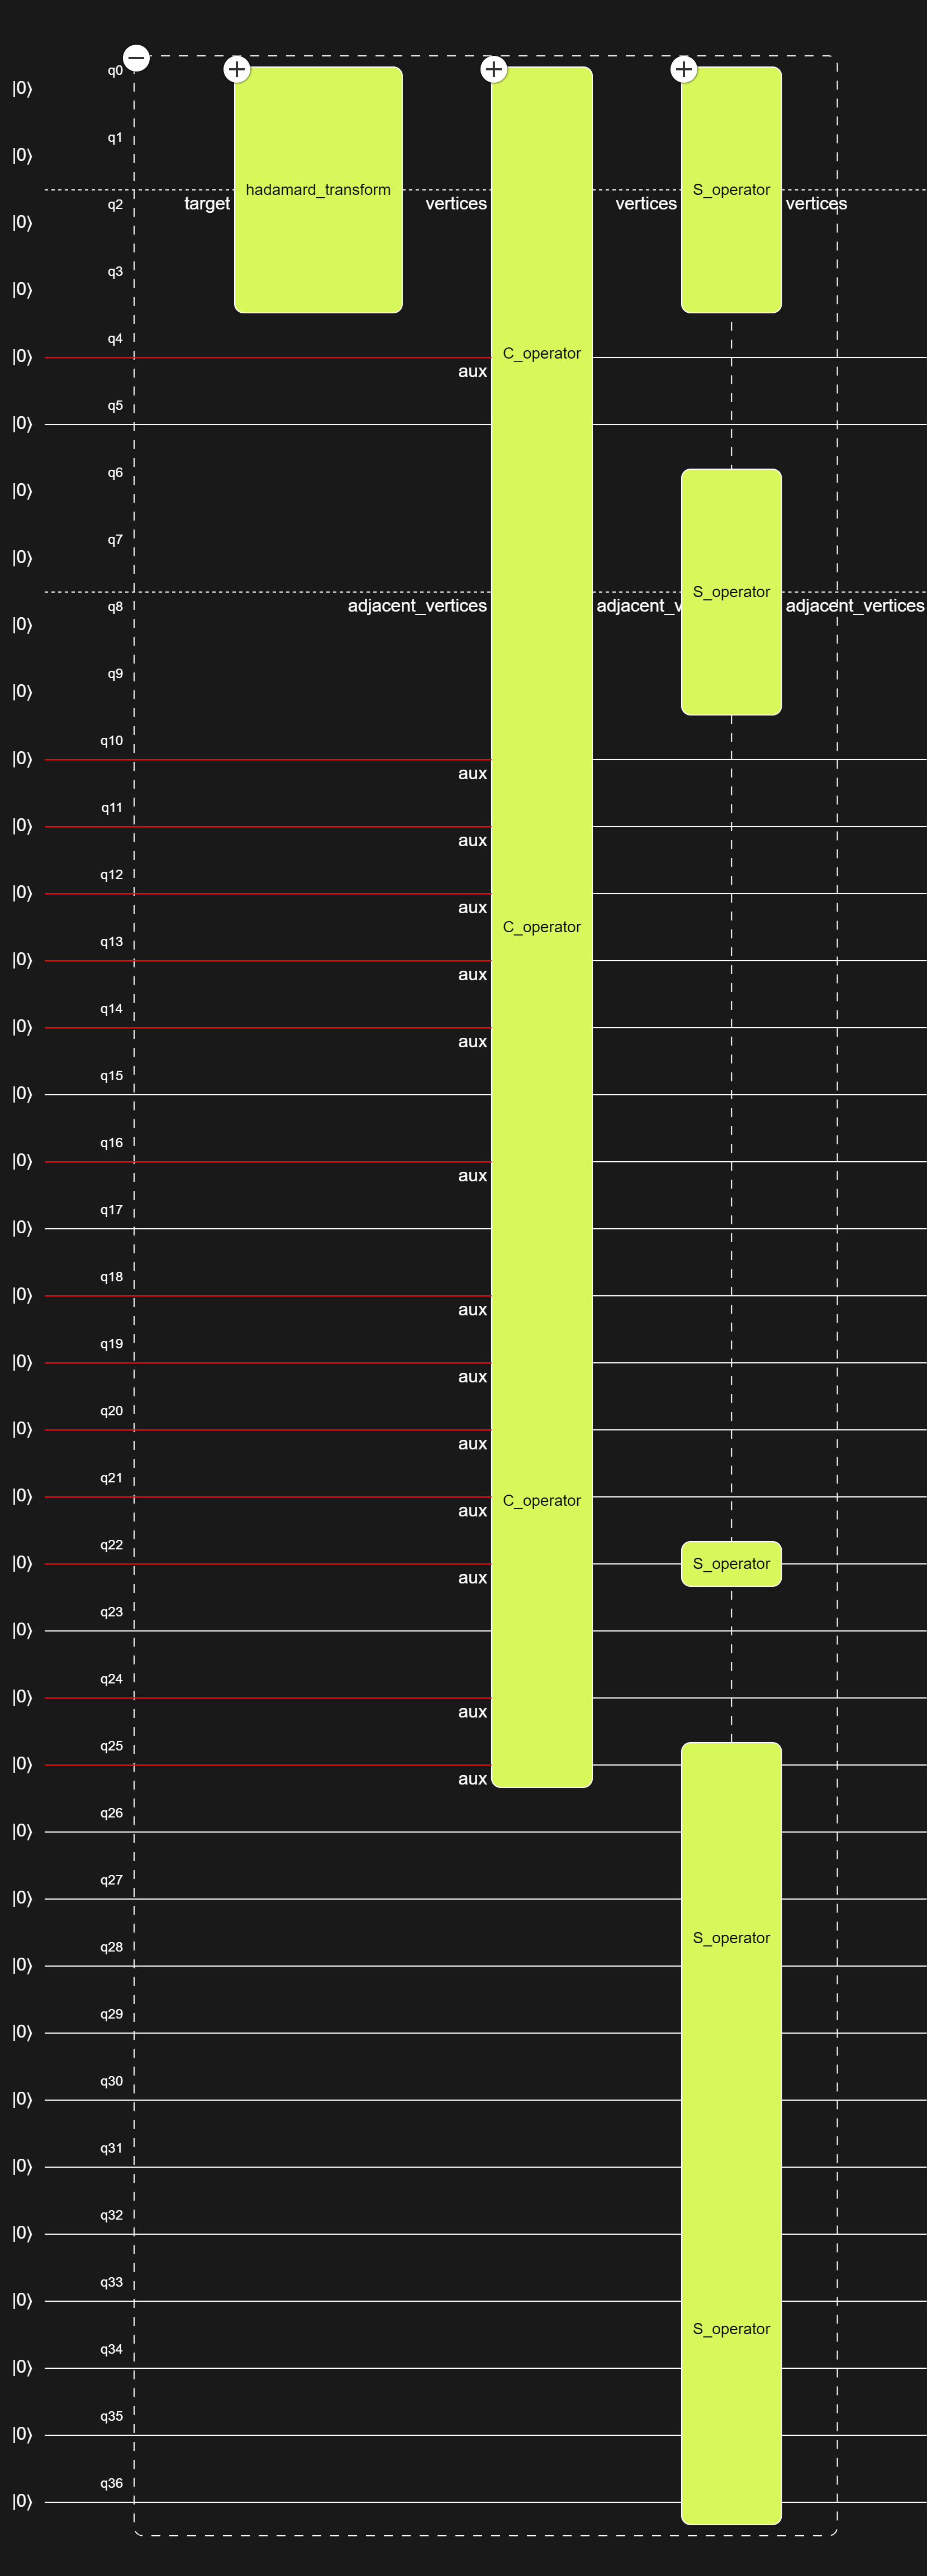

Various statistics of the original circuit:

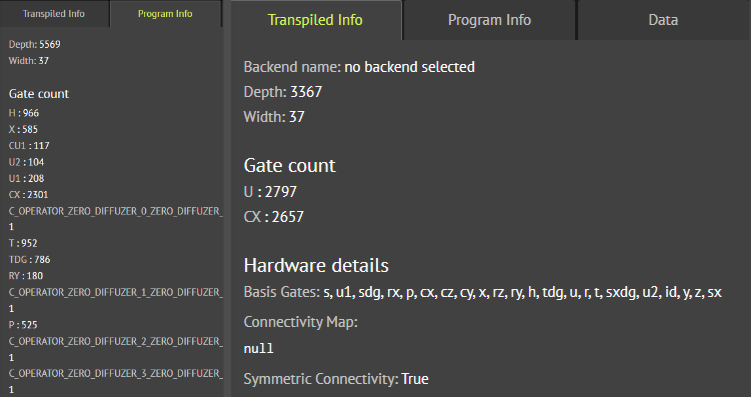

An overall view of the C(W)-Operator portion:

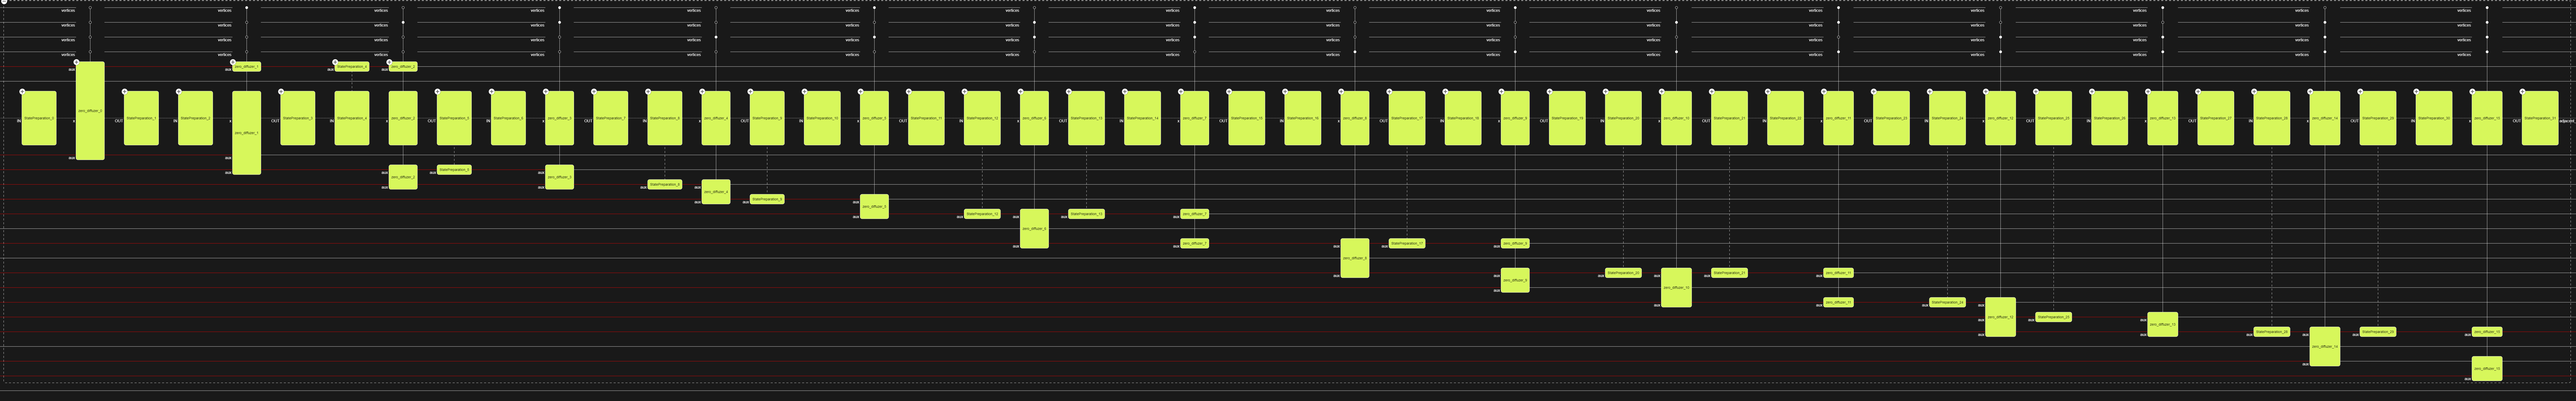

A more detailed view of the initial parts of C(W)-Operator portion:

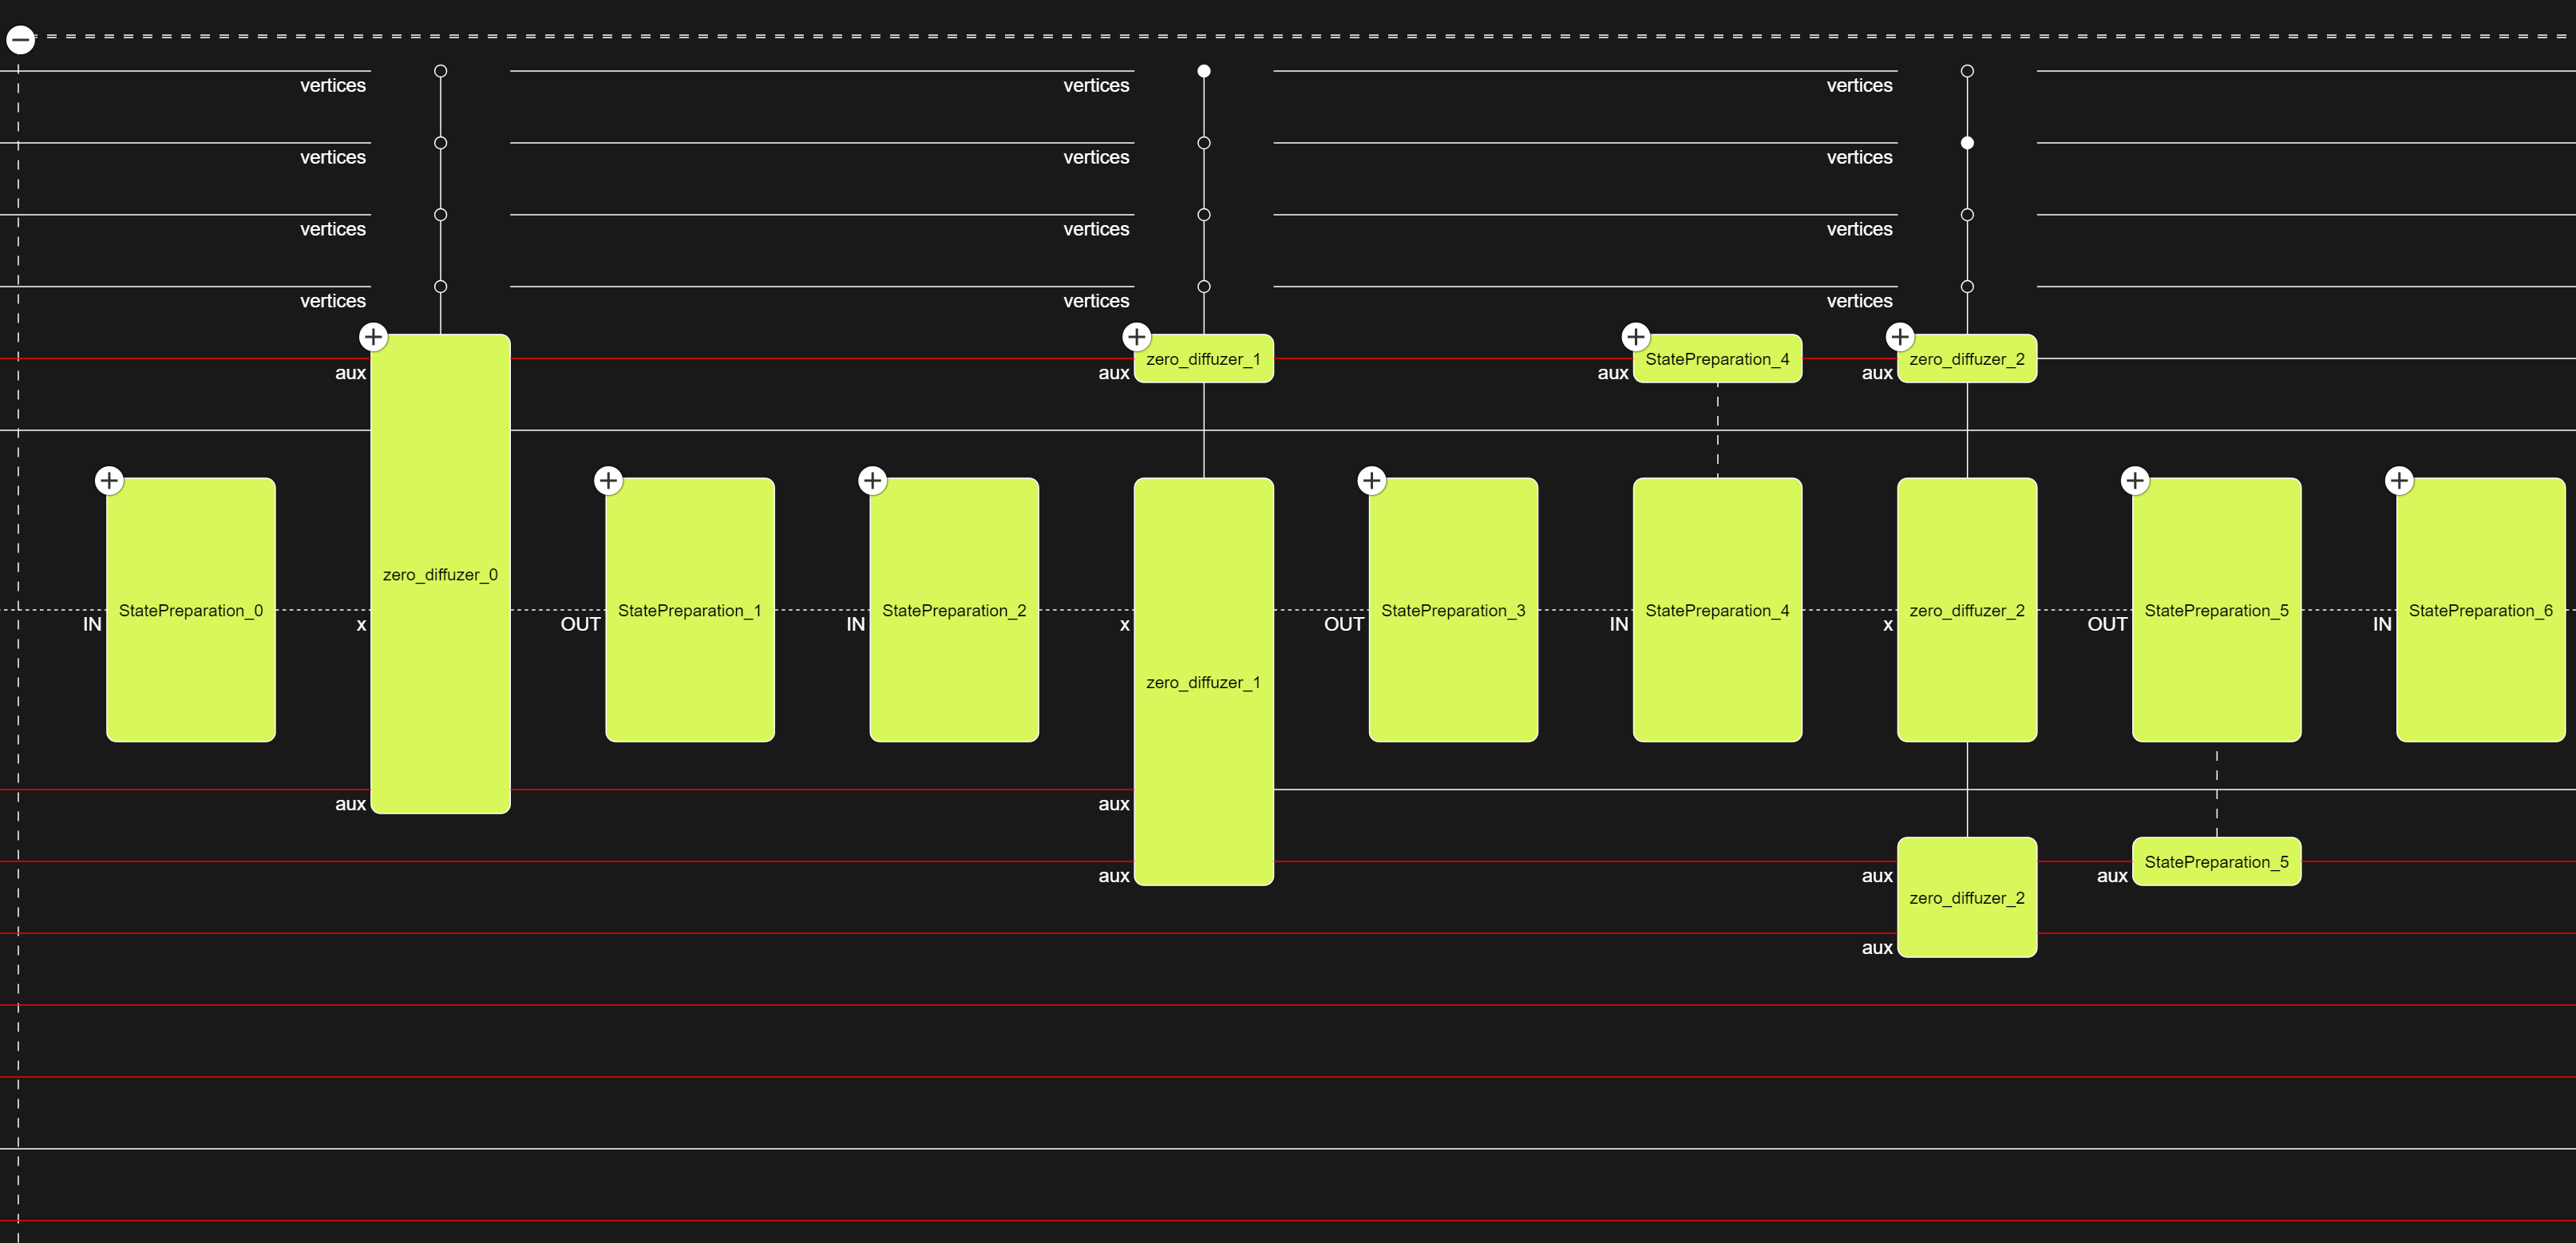

An overall view of the S-Operator portion:

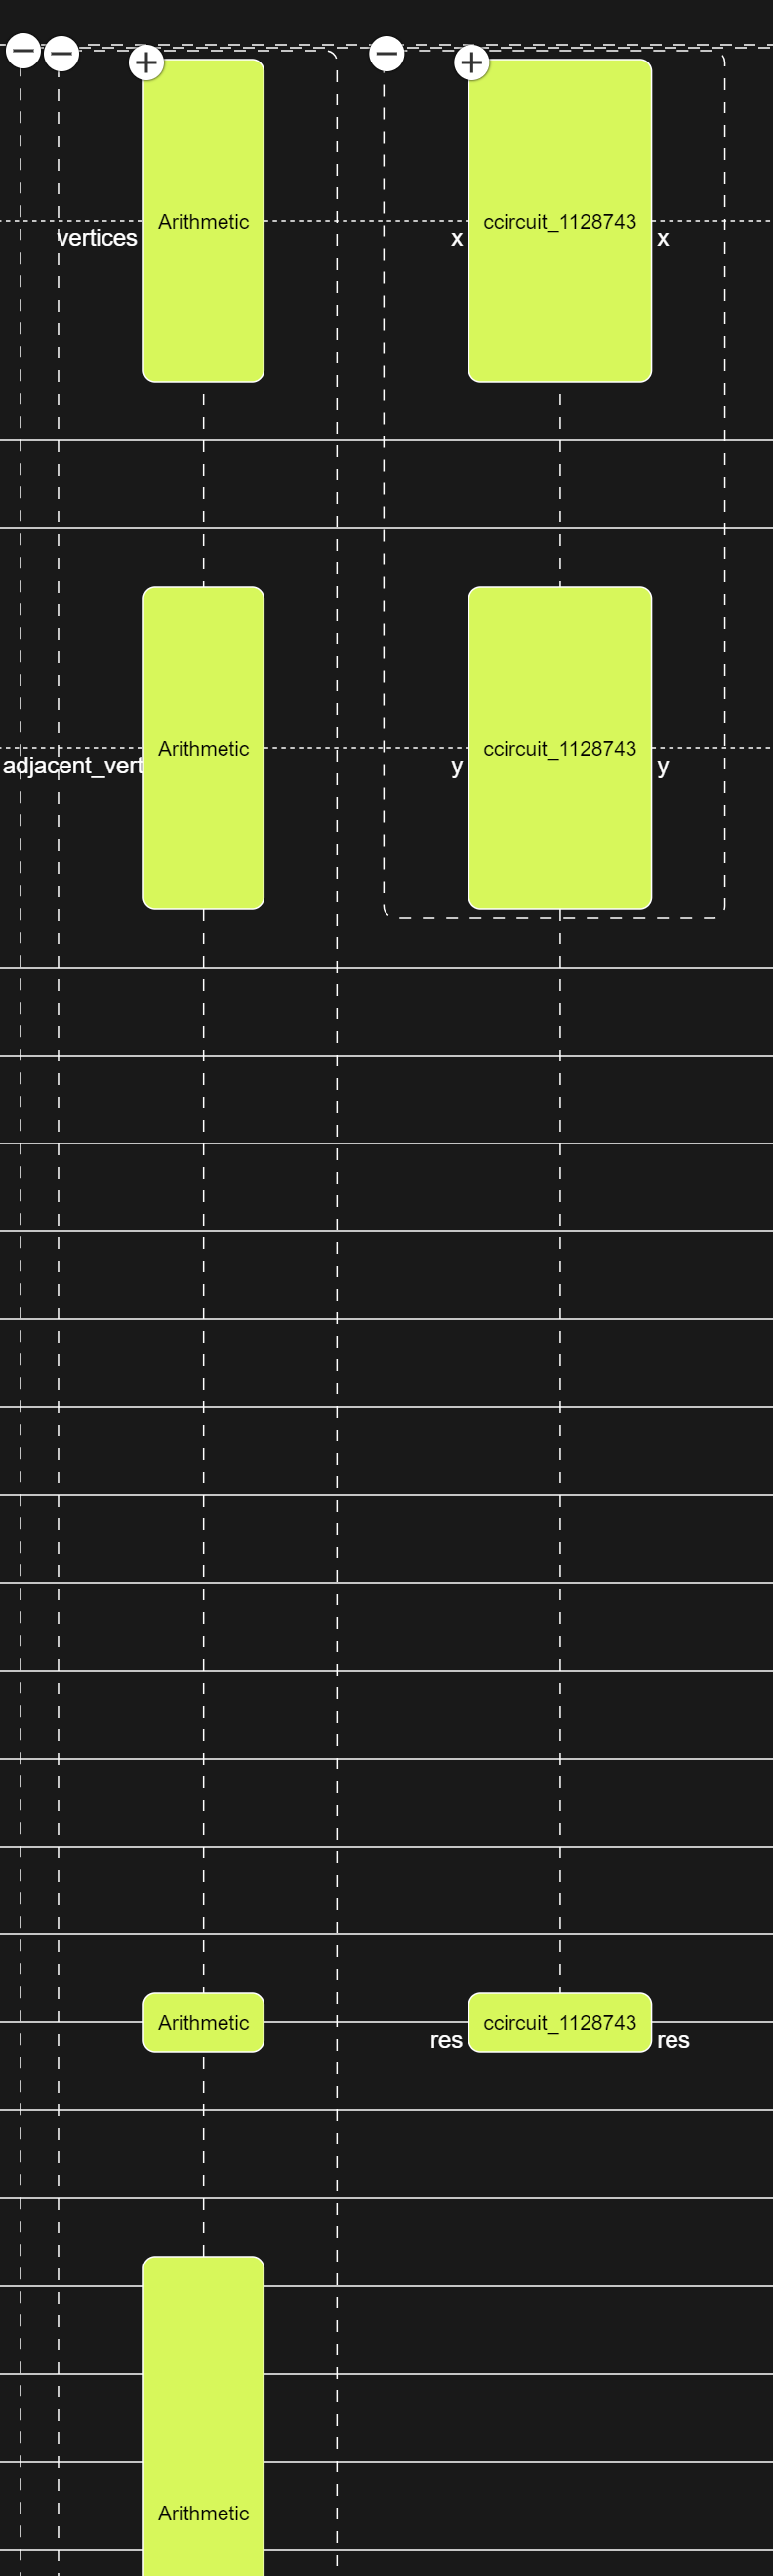

A more detailed view of the S-Operator portion:

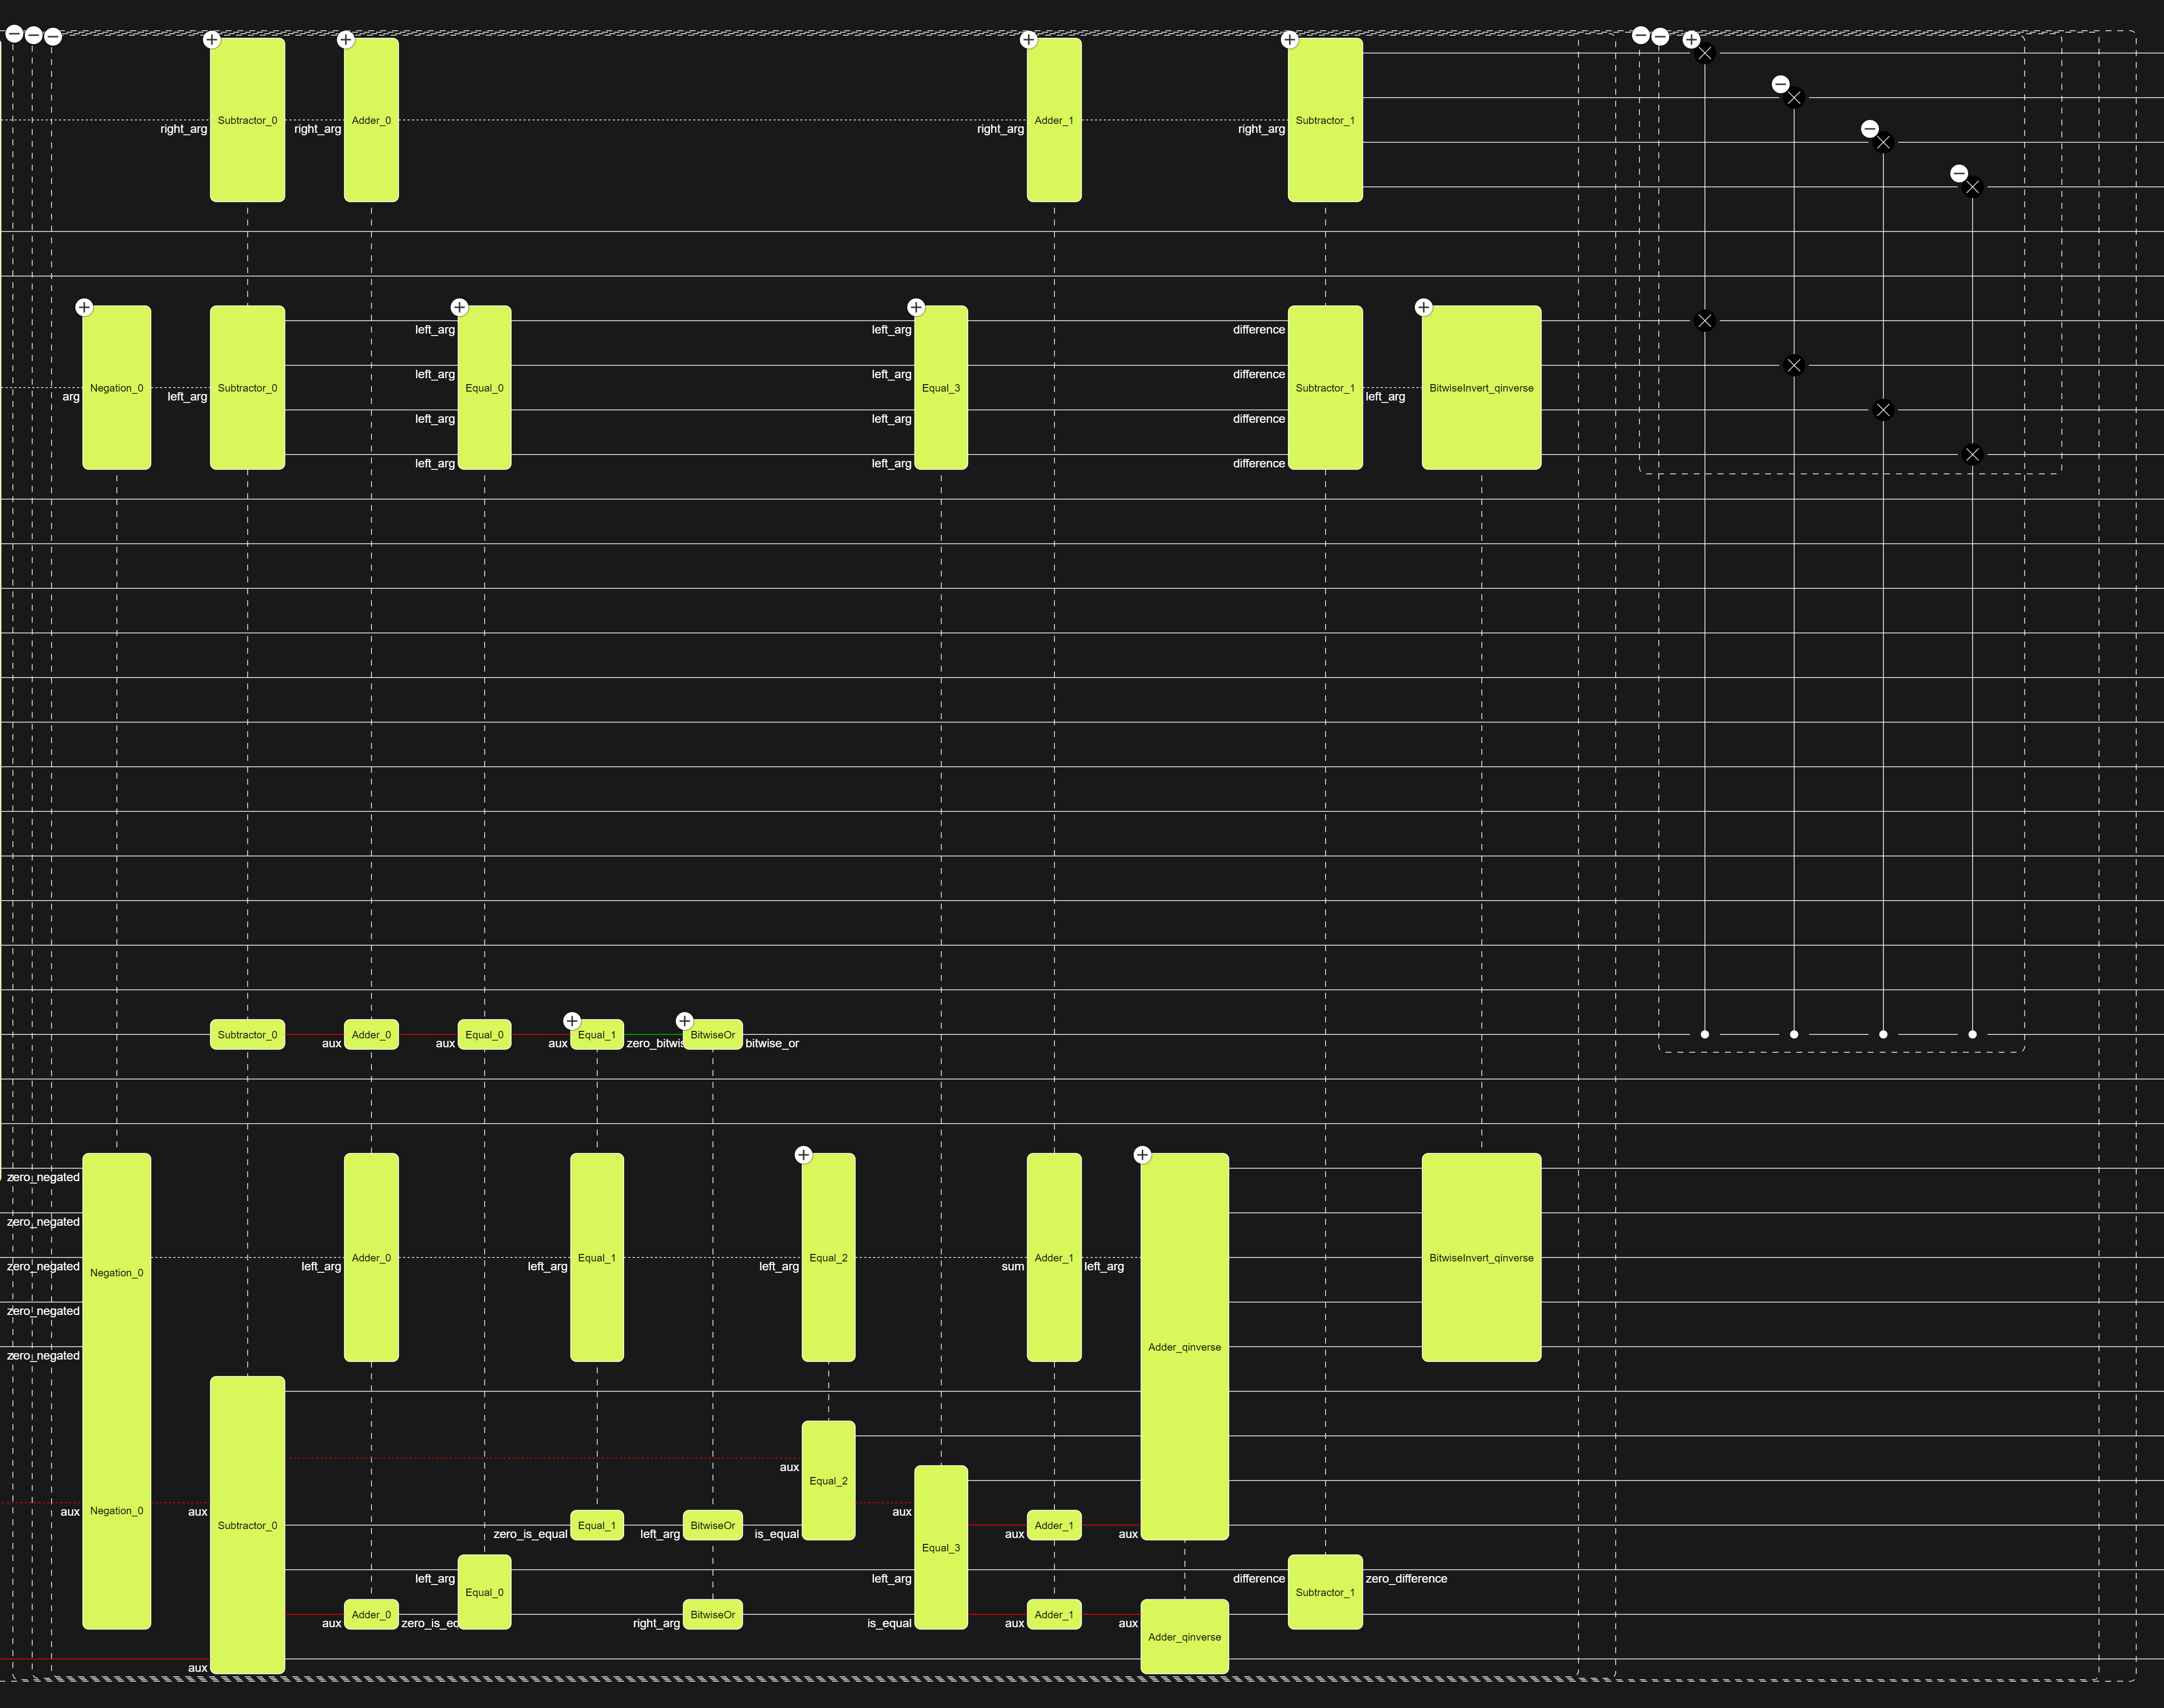

In [6]:
qmod12 = set_constraints(qmod11, Constraints(optimization_parameter="width"))
qprog12 = synthesize(qmod12)
show(qprog12)

Opening: https://platform.classiq.io/circuit/123bb6fe-23e7-4548-a8c3-decf7dcac3ff?version=0.43.3


The cell below and the output demonstrate the limitations for further illustration in this case (num_nodes=16)!

In [7]:
#qmod13 = set_constraints(qmod11, Constraints(optimization_parameter="depth", max_width=25))
#qprog13 = synthesize(qmod13)
#show(qprog13)

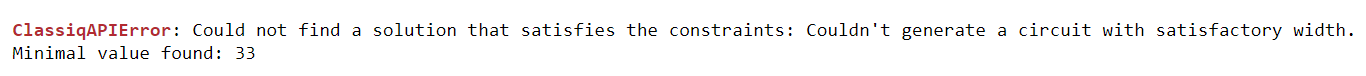

## Number of Nodes: 8

We only explore the measurement results and observations (as well as peculiarities) they bring with themselves to the discussion. As is evident, it can be percieved that with higher number of shots we can achieve a more uniform distribution of probabilities, representative of edges connecting the vertices. This is shown in the figure below in which the distributions can be observed for 1000, 2000, 5000, 10000, 20000 and 50000 shots from top left to bottom right! On the other hand, one question remains valid! Despite the fact that we have designed the edge oracle and probabilities of adjacent vertices to fit our scenario, in the results various irrelevant connectivities are reported, the likes of which we had not intended to obtain! For example, node 5 gets to be adjacent to node 0 (the 1000 shot case below), which should be against the expectations, at least personally! 

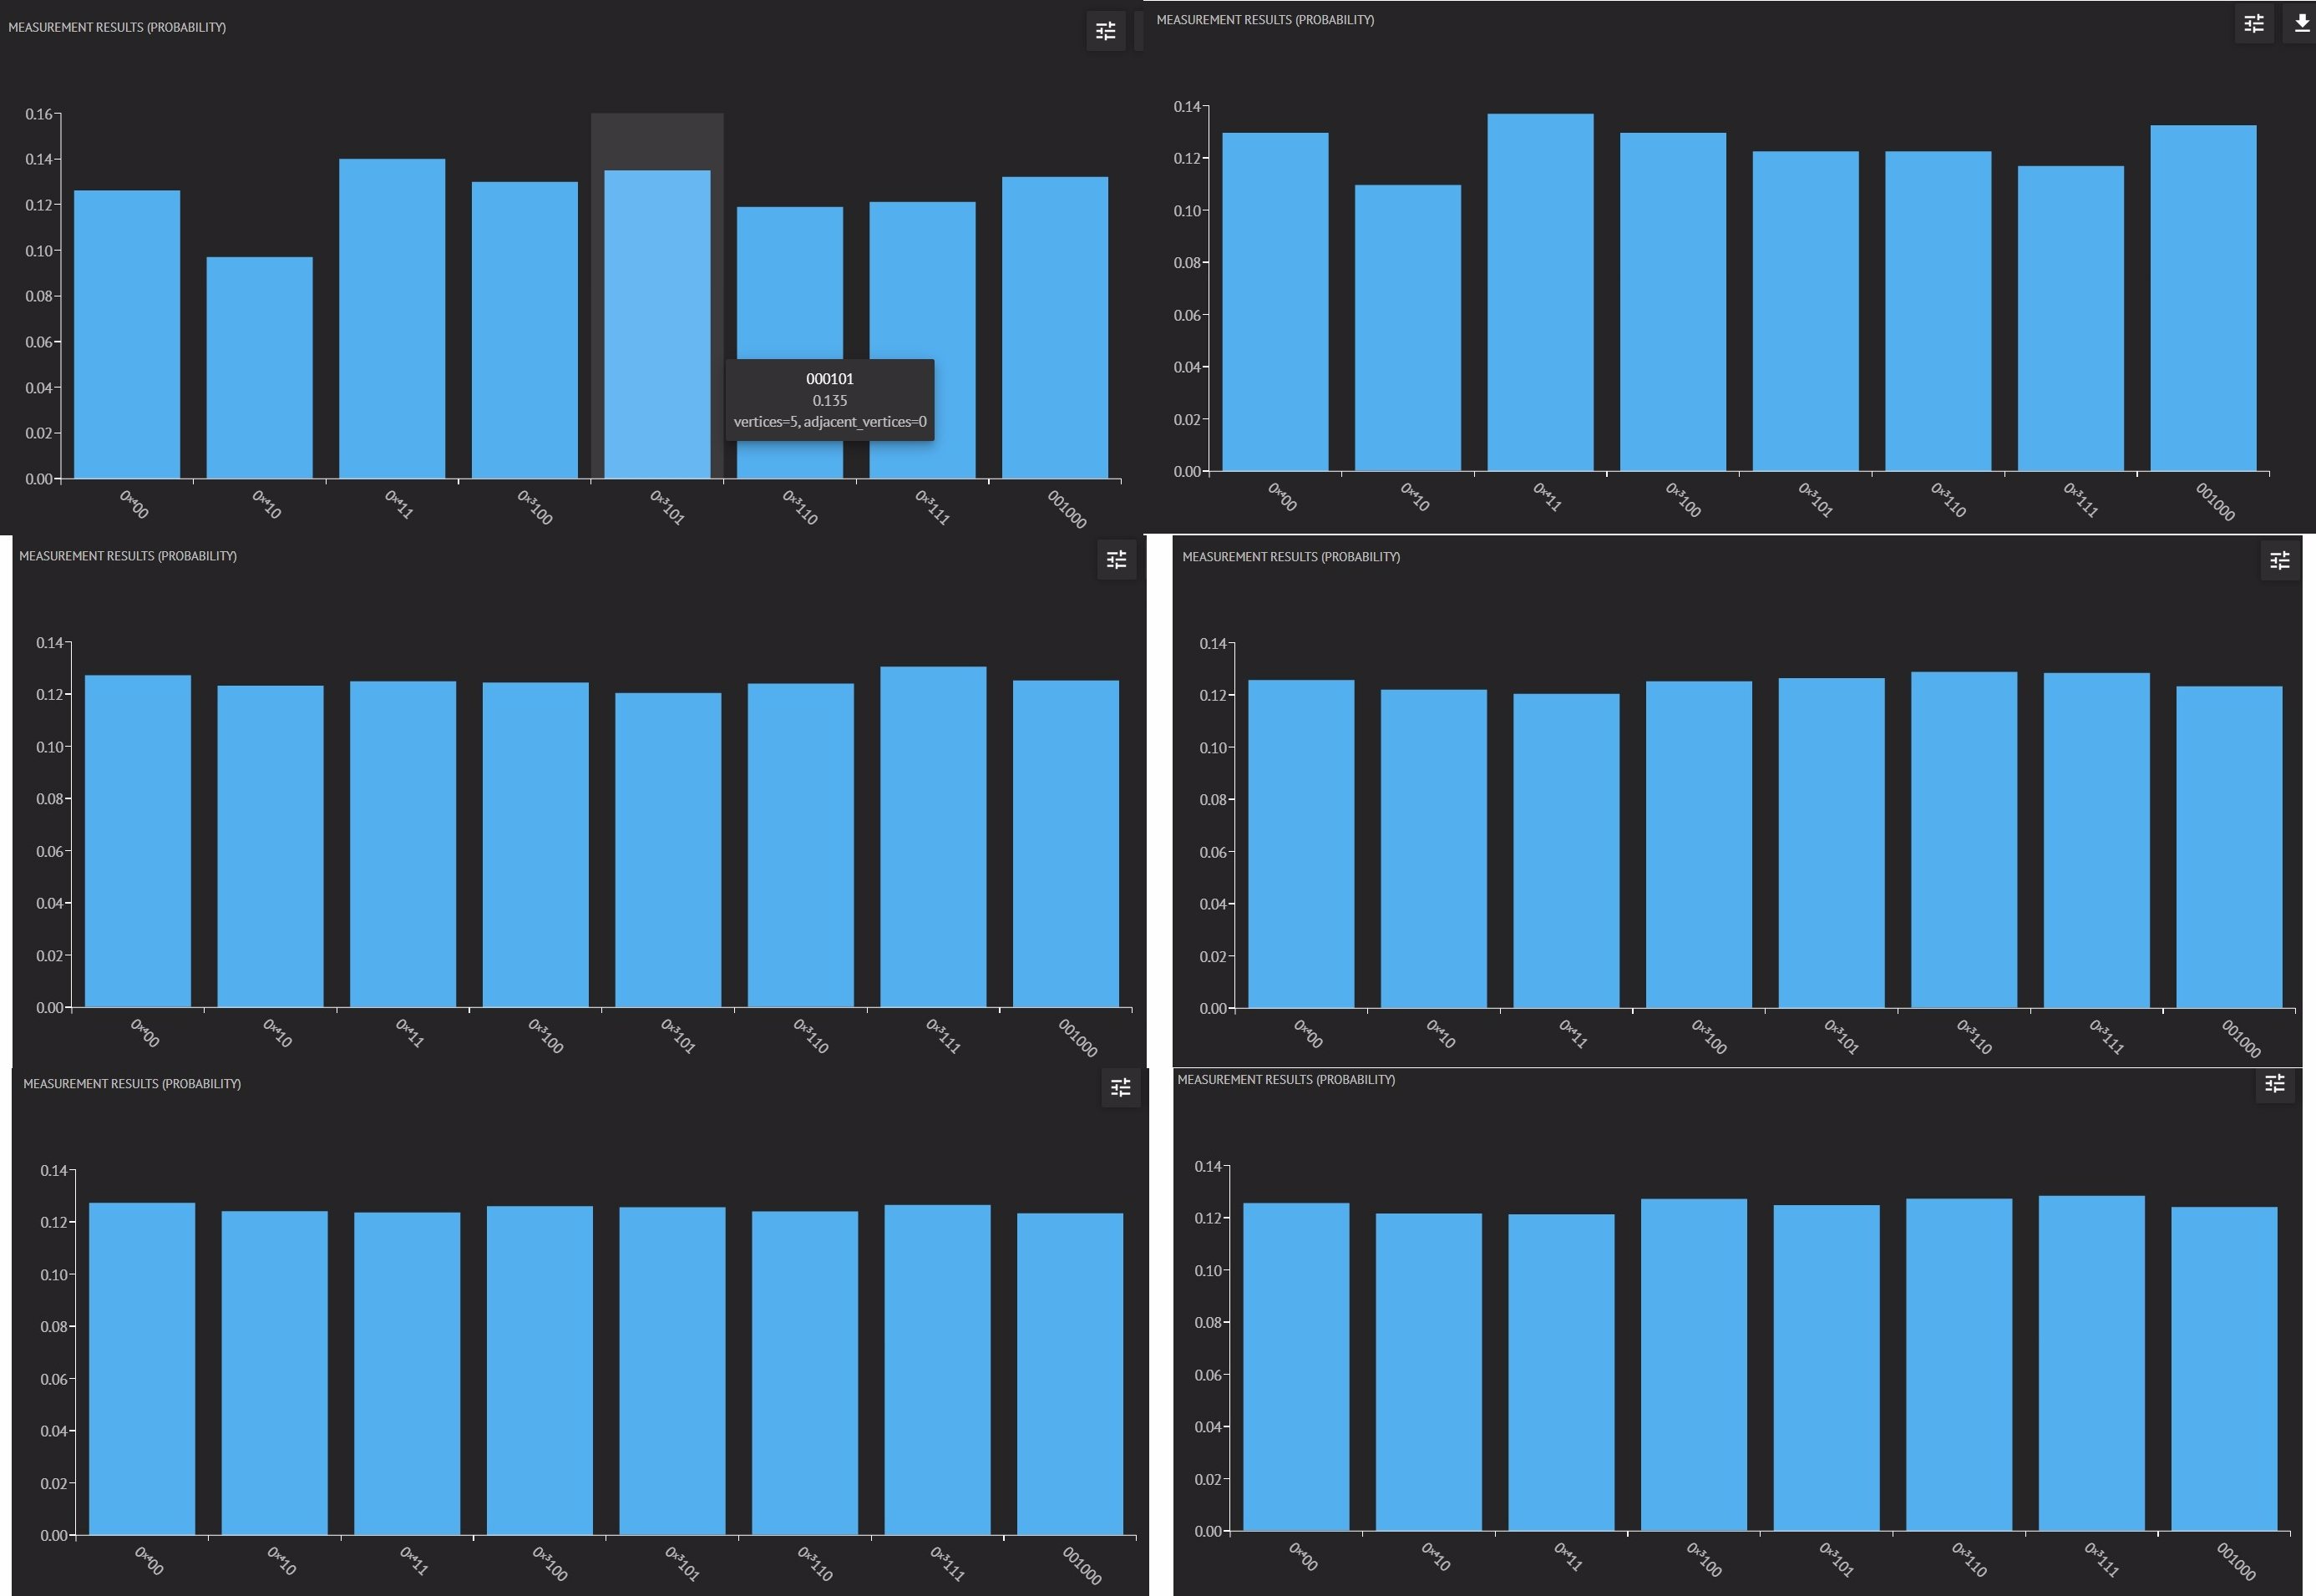

## Number of Nodes: 5

This case is entirely experimental, and I have not allocated sufficient time to thoroughly inspect it. But what if the number of nodes does not equal to 2 to the power of the number of qubits?
Maybe this case deserves attention because then we have to adjust the probs vector to suit our problem. The initial distinction between those two parameters (num_nodes and (2^num_q)) seems to address this case, except possibly a tweaking of the edge oracle according to the above (two doubts: one the probability vector for cases of i between num_nodes and (2^num_q)-1 and two adjusting the edge_oracle accordingly)? The vectors are as follows only after optimization for width, appropriate for a free account (because probability vectors can only consist of 2^n components):

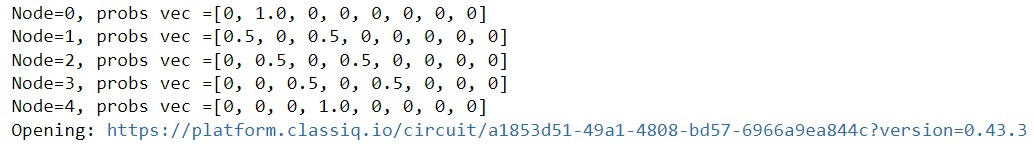

The corresponding C operator in the circuit indicative of the 5 values:

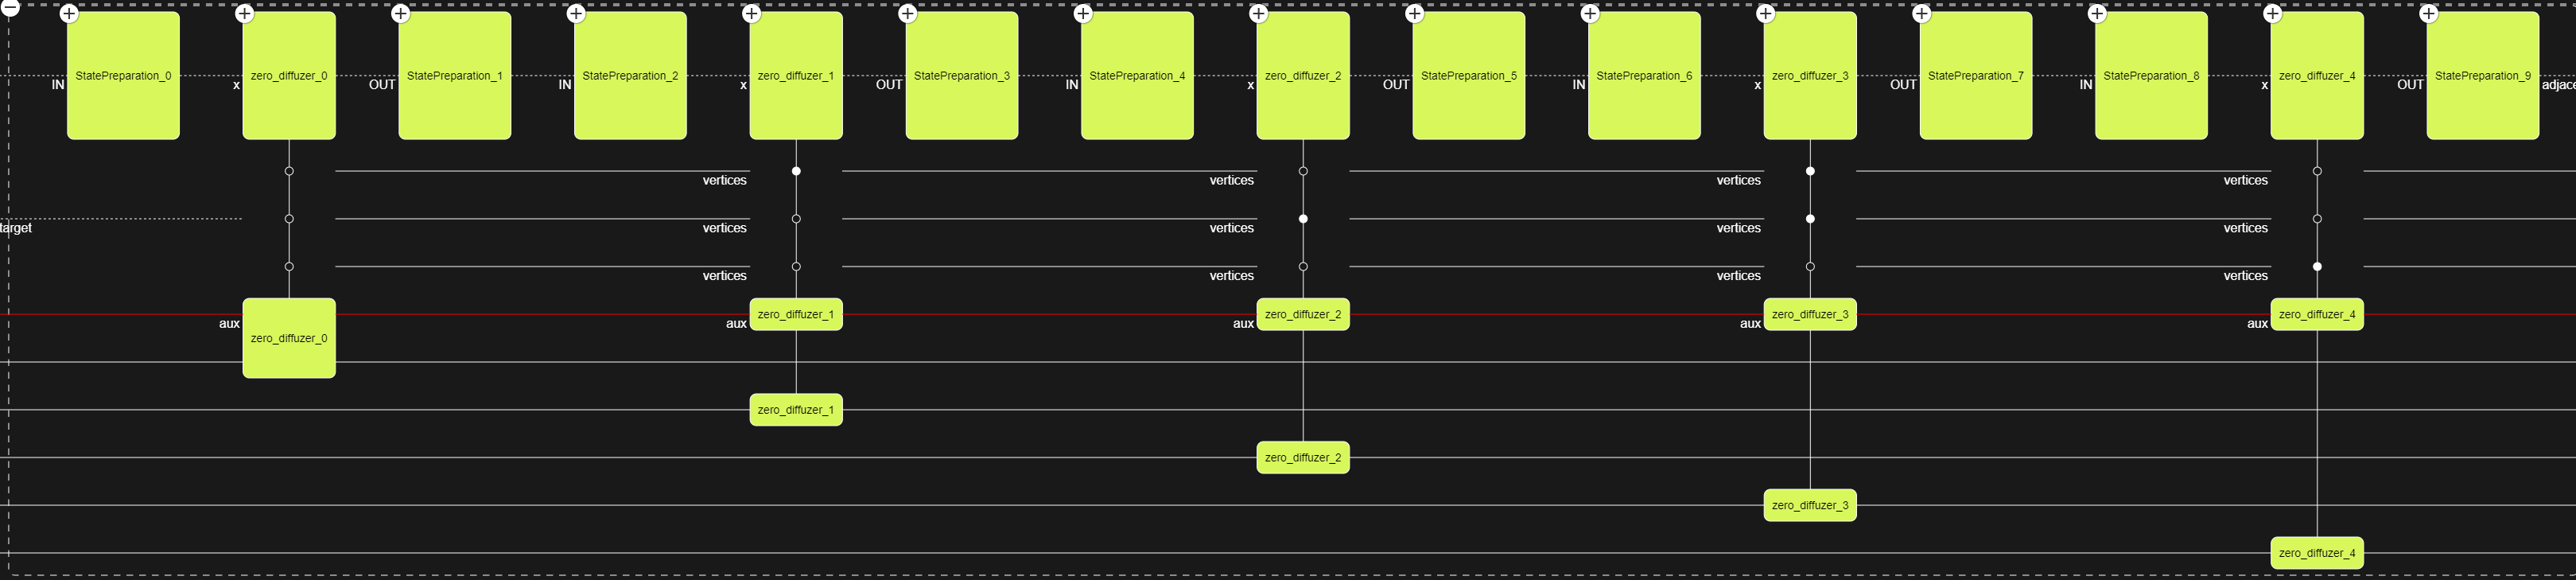

The measurements (this time truly incomprehensible - e.g., the existense of vertex 7) for 10000 shots: 

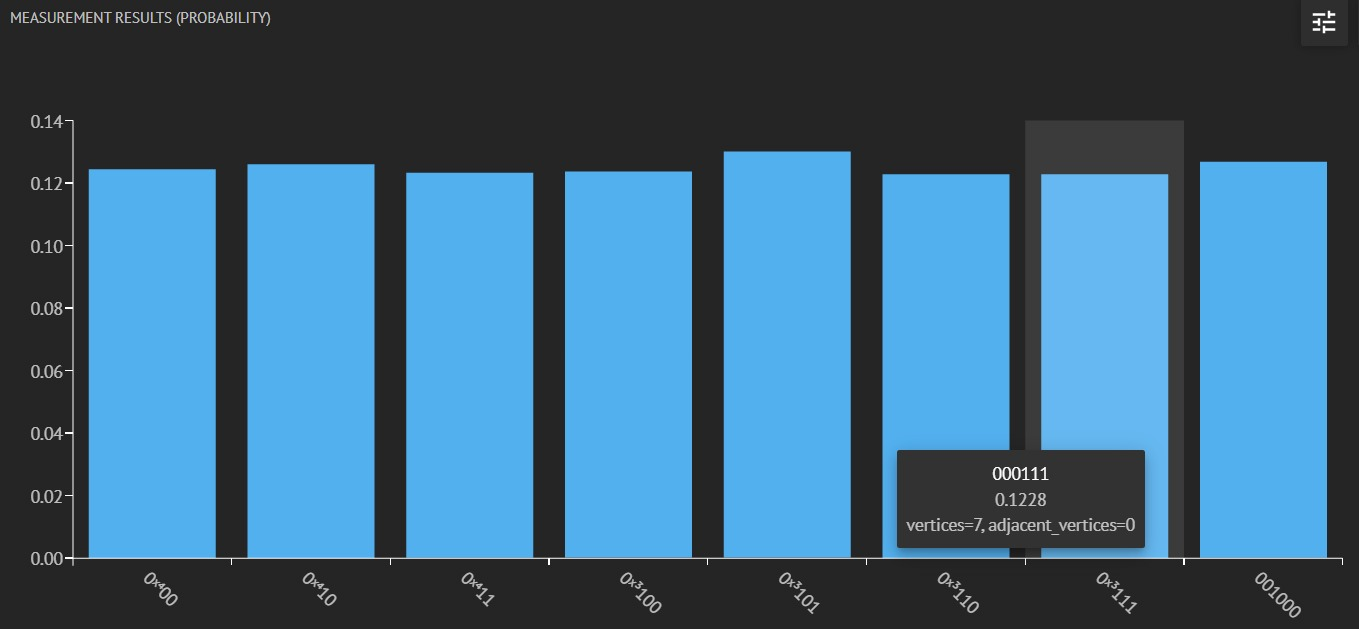

This case is quite confusing (most certainly because of missing something hence the need foe reinspection) and I would like to fathom both the meaning behind the interpretaion of the 8-node case and subsequently whether the implementation of this latest 5-node case makes sense (and if yes, how indeed it does)! It may be possible to manipulate it via prepare_amplitudes but still the dimension of the vector is essential! Perhaps I shall investigate it later!